<a href="https://colab.research.google.com/github/stepanjaburek/quantum_social_science_lr/blob/main/google_colab_pca_cluster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
###################################
# PCA and cluster analysis
###############################
# setup
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
dp = pd.read_csv("/content/0_kw_analysis.csv")

##############################
# We can afterwards create dummies for the concept either mentioned or not
# !Very different results!
# dp.iloc[:, 1:43] = (dp.iloc[:, 1:43] > 0).astype(int)
#######################################x

###
# define the variables of interest
filenames = dp['filename']
features = dp.drop('filename', axis=1)

Explained variance ratio: [0.11231758 0.09679383 0.05441142 0.04004629 0.0345402 ]


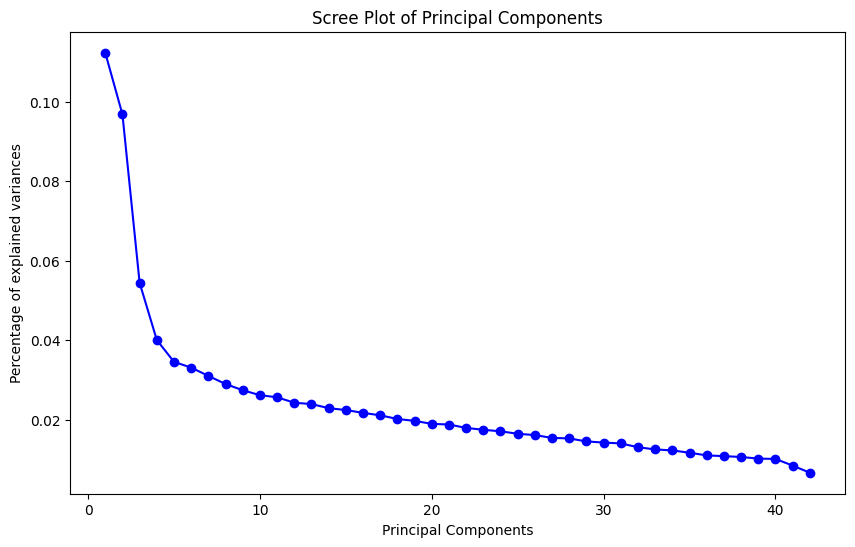

                                         feature    PC   loading
khrennikov                            khrennikov   PC1  0.293661
interference                        interference   PC1  0.288460
busemeyer                              busemeyer   PC1  0.280599
hilbert space                      hilbert space   PC1  0.270600
psychology                            psychology   PC1  0.239425
...                                          ...   ...       ...
wendt                                      wendt  PC42  0.755311
international relations  international relations  PC42 -0.457721
barad                                      barad  PC42 -0.283917
social science                    social science  PC42 -0.232690
ethics                                    ethics  PC42  0.094697

[210 rows x 3 columns]
                                         feature   PC   loading
khrennikov                            khrennikov  PC1  0.293661
interference                        interference  PC1  0.288460
buse

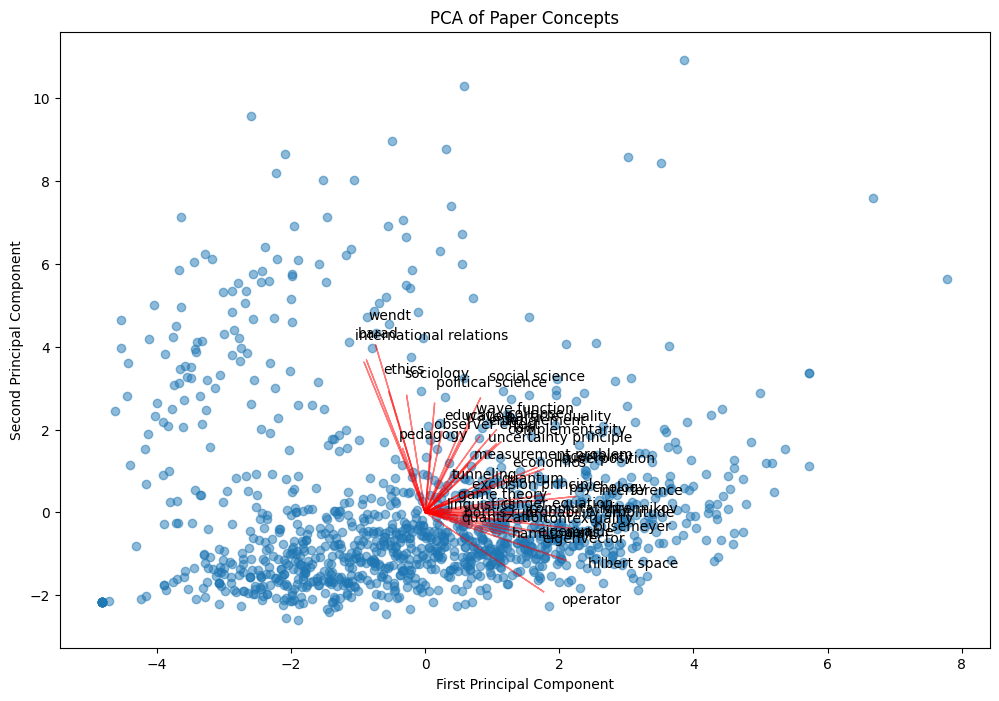

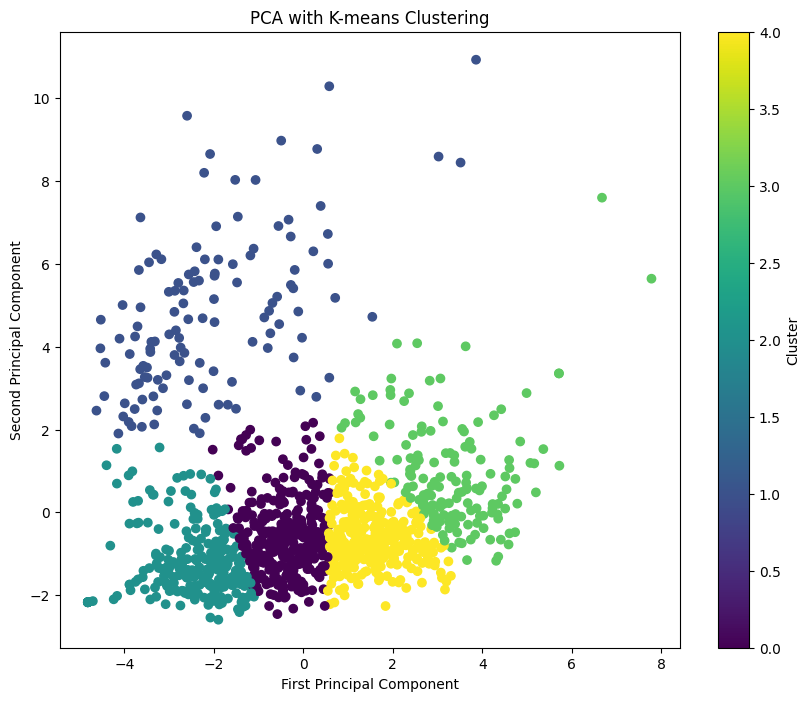

In [ ]:
# Run PCA
pca = PCA()
features_scaled = StandardScaler().fit_transform(features)
pca_result = pca.fit_transform(features_scaled)
print("Explained variance ratio:", pca.explained_variance_ratio_[:5])

# Scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         pca.explained_variance_ratio_, 'bo-')
plt.title('Scree Plot of Principal Components')
plt.xlabel('Principal Components')
plt.ylabel('Percentage of explained variances')
plt.show()

# Feature importance in components
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(len(pca.components_))],
    index=features.columns
)

# top 5 features per component
top_loadings = pd.DataFrame()
for pc in loadings.columns:
    top_5 = pd.DataFrame({
        'feature': loadings.index,
        'PC': pc,
        'loading': loadings[pc]
    })
    # Sort by absolute values manually
    top_5 = top_5.reindex(top_5['loading'].abs().sort_values(ascending=False).index)
    top_5 = top_5.head(5)
    top_loadings = pd.concat([top_loadings, top_5])



print(top_loadings)


# PC1 and 2
pc12_loadings = top_loadings[top_loadings['PC'].isin(['PC1', 'PC2'])]
pc12_loadings = pc12_loadings.sort_values(['PC', 'loading'],
                                         ascending=[True, False])
print(pc12_loadings)

# PCA biplot
plt.figure(figsize=(12, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)

for i, feature in enumerate(features.columns):
    plt.arrow(0, 0,
              pca.components_[0, i]*max(abs(pca_result[:, 0])),
              pca.components_[1, i]*max(abs(pca_result[:, 1])),
              color='r', alpha=0.5)
    plt.text(pca.components_[0, i]*max(abs(pca_result[:, 0]))*1.15,
             pca.components_[1, i]*max(abs(pca_result[:, 1]))*1.15,
             feature)

plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA of Paper Concepts')
plt.show()

###################################
# cluster analysis
np.random.seed(456)
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters)
clusters = kmeans.fit_predict(pca_result[:, :2])

# visualize clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1],
                     c=clusters, cmap='viridis')
plt.colorbar(scatter, label='Cluster')
plt.title('PCA with K-means Clustering')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

<Figure size 1000x800 with 0 Axes>

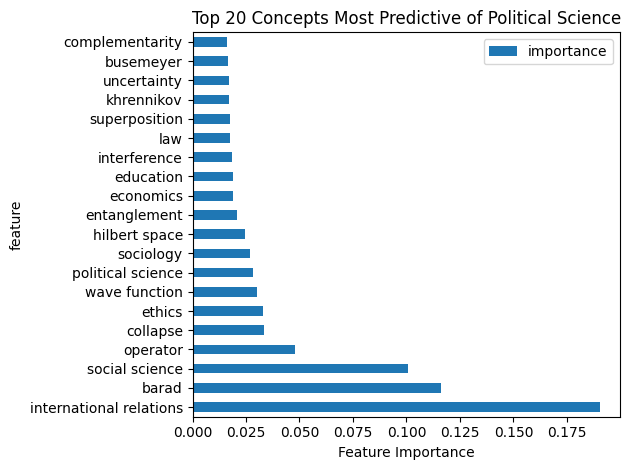

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Prepare data
target = features['wendt']
predictors = features.drop('wendt', axis=1)

# Fit random forest
#rf = RandomForestRegressor(n_estimators=1500, random_state=123)
rf = RandomForestClassifier(n_estimators=1000, random_state=123)
rf.fit(predictors, target)

# Get feature importance
importance_df = pd.DataFrame({
    'feature': predictors.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 20
plt.figure(figsize=(10, 8))
importance_df.head(20).plot(kind='barh', x='feature', y='importance')
plt.title('Top 20 Concepts Most Predictive of Political Science')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()